In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc,
                            accuracy_score, precision_score, recall_score, f1_score,
                            roc_auc_score)
import joblib
import warnings
warnings.filterwarnings('ignore')

In [17]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ===============================
# 1. LOAD PREPROCESSED DATA
# ===============================

In [18]:
# Load selected features and target
X_selected = pd.read_csv('../Data/X_selected_features.csv')
y = pd.read_csv('../Data/y_target.csv').squeeze()
    
print(f" Loaded selected features: {X_selected.shape}")
print(f" Loaded target variable: {y.shape}")
print(f" Selected features: {list(X_selected.columns)}")
print(f" Target distribution: {y.value_counts().to_dict()}")

 Loaded selected features: (303, 10)
 Loaded target variable: (303,)
 Selected features: ['PC1', 'PC2', 'PC4', 'PC9', 'PC5', 'PC6', 'PC7', 'PC3', 'PC8', 'PC10']
 Target distribution: {0: 164, 1: 139}


# ===============================
# 2. TRAIN-TEST SPLIT
# ===============================

In [19]:
# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_selected)*100:.1f}%)")
print(f" Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_selected)*100:.1f}%)")
print(f" Training target distribution: {y_train.value_counts().to_dict()}")
print(f" Test target distribution: {y_test.value_counts().to_dict()}")


 Training set: 242 samples (79.9%)
 Test set: 61 samples (20.1%)
 Training target distribution: {0: 131, 1: 111}
 Test target distribution: {0: 33, 1: 28}


# ===============================
# 3. MODEL INITIALIZATION
# ===============================

In [20]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

print(" Initialized models:")
for name, model in models.items():
    print(f"   • {name}: {type(model).__name__}")


 Initialized models:
   • Logistic Regression: LogisticRegression
   • Decision Tree: DecisionTreeClassifier
   • Random Forest: RandomForestClassifier
   • Support Vector Machine: SVC


# ===============================
# 4. MODEL TRAINING AND EVALUATION
# ===============================

In [26]:
# Store results
results = {}
cv_results = []

# Cross-validation setup
cv_folds = 10
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

print(" Training models with cross-validation...")

for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='accuracy')
    cv_precision = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='precision')
    cv_recall = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='recall')
    cv_f1 = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='f1')
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Prediction probabilities (for ROC curve)
    if hasattr(model, 'predict_proba'):
        y_test_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_test_proba = model.decision_function(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    # Store results
    results[name] = {
        'model': model,
        'cv_accuracy': cv_scores,
        'cv_precision': cv_precision,
        'cv_recall': cv_recall,
        'cv_f1': cv_f1,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'test_precision': test_precision,
        'test_recall': test_recall,
        'test_f1': test_f1,
        'test_auc': test_auc,
        'y_test_pred': y_test_pred,
        'y_test_proba': y_test_proba
    }
    
    # Store for DataFrame
    cv_results.append({
        'Model': name,
        'CV_Accuracy_Mean': cv_scores.mean(),
        'CV_Accuracy_Std': cv_scores.std(),
        'CV_Precision_Mean': cv_precision.mean(),
        'CV_Recall_Mean': cv_recall.mean(),
        'CV_F1_Mean': cv_f1.mean(),
        'Train_Accuracy': train_accuracy,
        'Test_Accuracy': test_accuracy,
        'Test_Precision': test_precision,
        'Test_Recall': test_recall,
        'Test_F1': test_f1,
        'Test_AUC': test_auc
    })
    
    print(f"    CV Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    print(f"    Test Accuracy: {test_accuracy:.4f}")
    print(f"    Test AUC: {test_auc:.4f}")

 Training models with cross-validation...

 Training Logistic Regression...
    CV Accuracy: 0.8183 (±0.0482)
    Test Accuracy: 0.8852
    Test AUC: 0.9459

 Training Decision Tree...
    CV Accuracy: 0.7350 (±0.0666)
    Test Accuracy: 0.7705
    Test AUC: 0.7771

 Training Random Forest...
    CV Accuracy: 0.8137 (±0.0792)
    Test Accuracy: 0.8852
    Test AUC: 0.9378

 Training Support Vector Machine...
    CV Accuracy: 0.8345 (±0.0526)
    Test Accuracy: 0.8525
    Test AUC: 0.9280


# ===============================
# 5. RESULTS COMPARISON
# ===============================

In [22]:
# Convert results to DataFrame
results_df = pd.DataFrame(cv_results)
print(" Comprehensive Model Performance:")
print(results_df.round(4))

# Find best model
best_model_idx = results_df['CV_Accuracy_Mean'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = results[best_model_name]['model']

print(f"\n Best Model: {best_model_name}")
print(f"    CV Accuracy: {results_df.loc[best_model_idx, 'CV_Accuracy_Mean']:.4f}")
print(f"    Test Accuracy: {results_df.loc[best_model_idx, 'Test_Accuracy']:.4f}")
print(f"    Test AUC: {results_df.loc[best_model_idx, 'Test_AUC']:.4f}")


 Comprehensive Model Performance:
                    Model  CV_Accuracy_Mean  CV_Accuracy_Std  \
0     Logistic Regression            0.8183           0.0482   
1           Decision Tree            0.7350           0.0666   
2           Random Forest            0.8137           0.0792   
3  Support Vector Machine            0.8345           0.0526   

   CV_Precision_Mean  CV_Recall_Mean  CV_F1_Mean  Train_Accuracy  \
0             0.8507          0.7576      0.7914          0.8471   
1             0.7252          0.7288      0.7154          1.0000   
2             0.8161          0.7932      0.7970          1.0000   
3             0.8643          0.7750      0.8095          0.8926   

   Test_Accuracy  Test_Precision  Test_Recall  Test_F1  Test_AUC  
0         0.8852          0.8182       0.9643   0.8852    0.9459  
1         0.7705          0.7059       0.8571   0.7742    0.7771  
2         0.8852          0.8889       0.8571   0.8727    0.9378  
3         0.8525          0.8065    

# ===============================
# 6. DETAILED VISUALIZATION
# ===============================

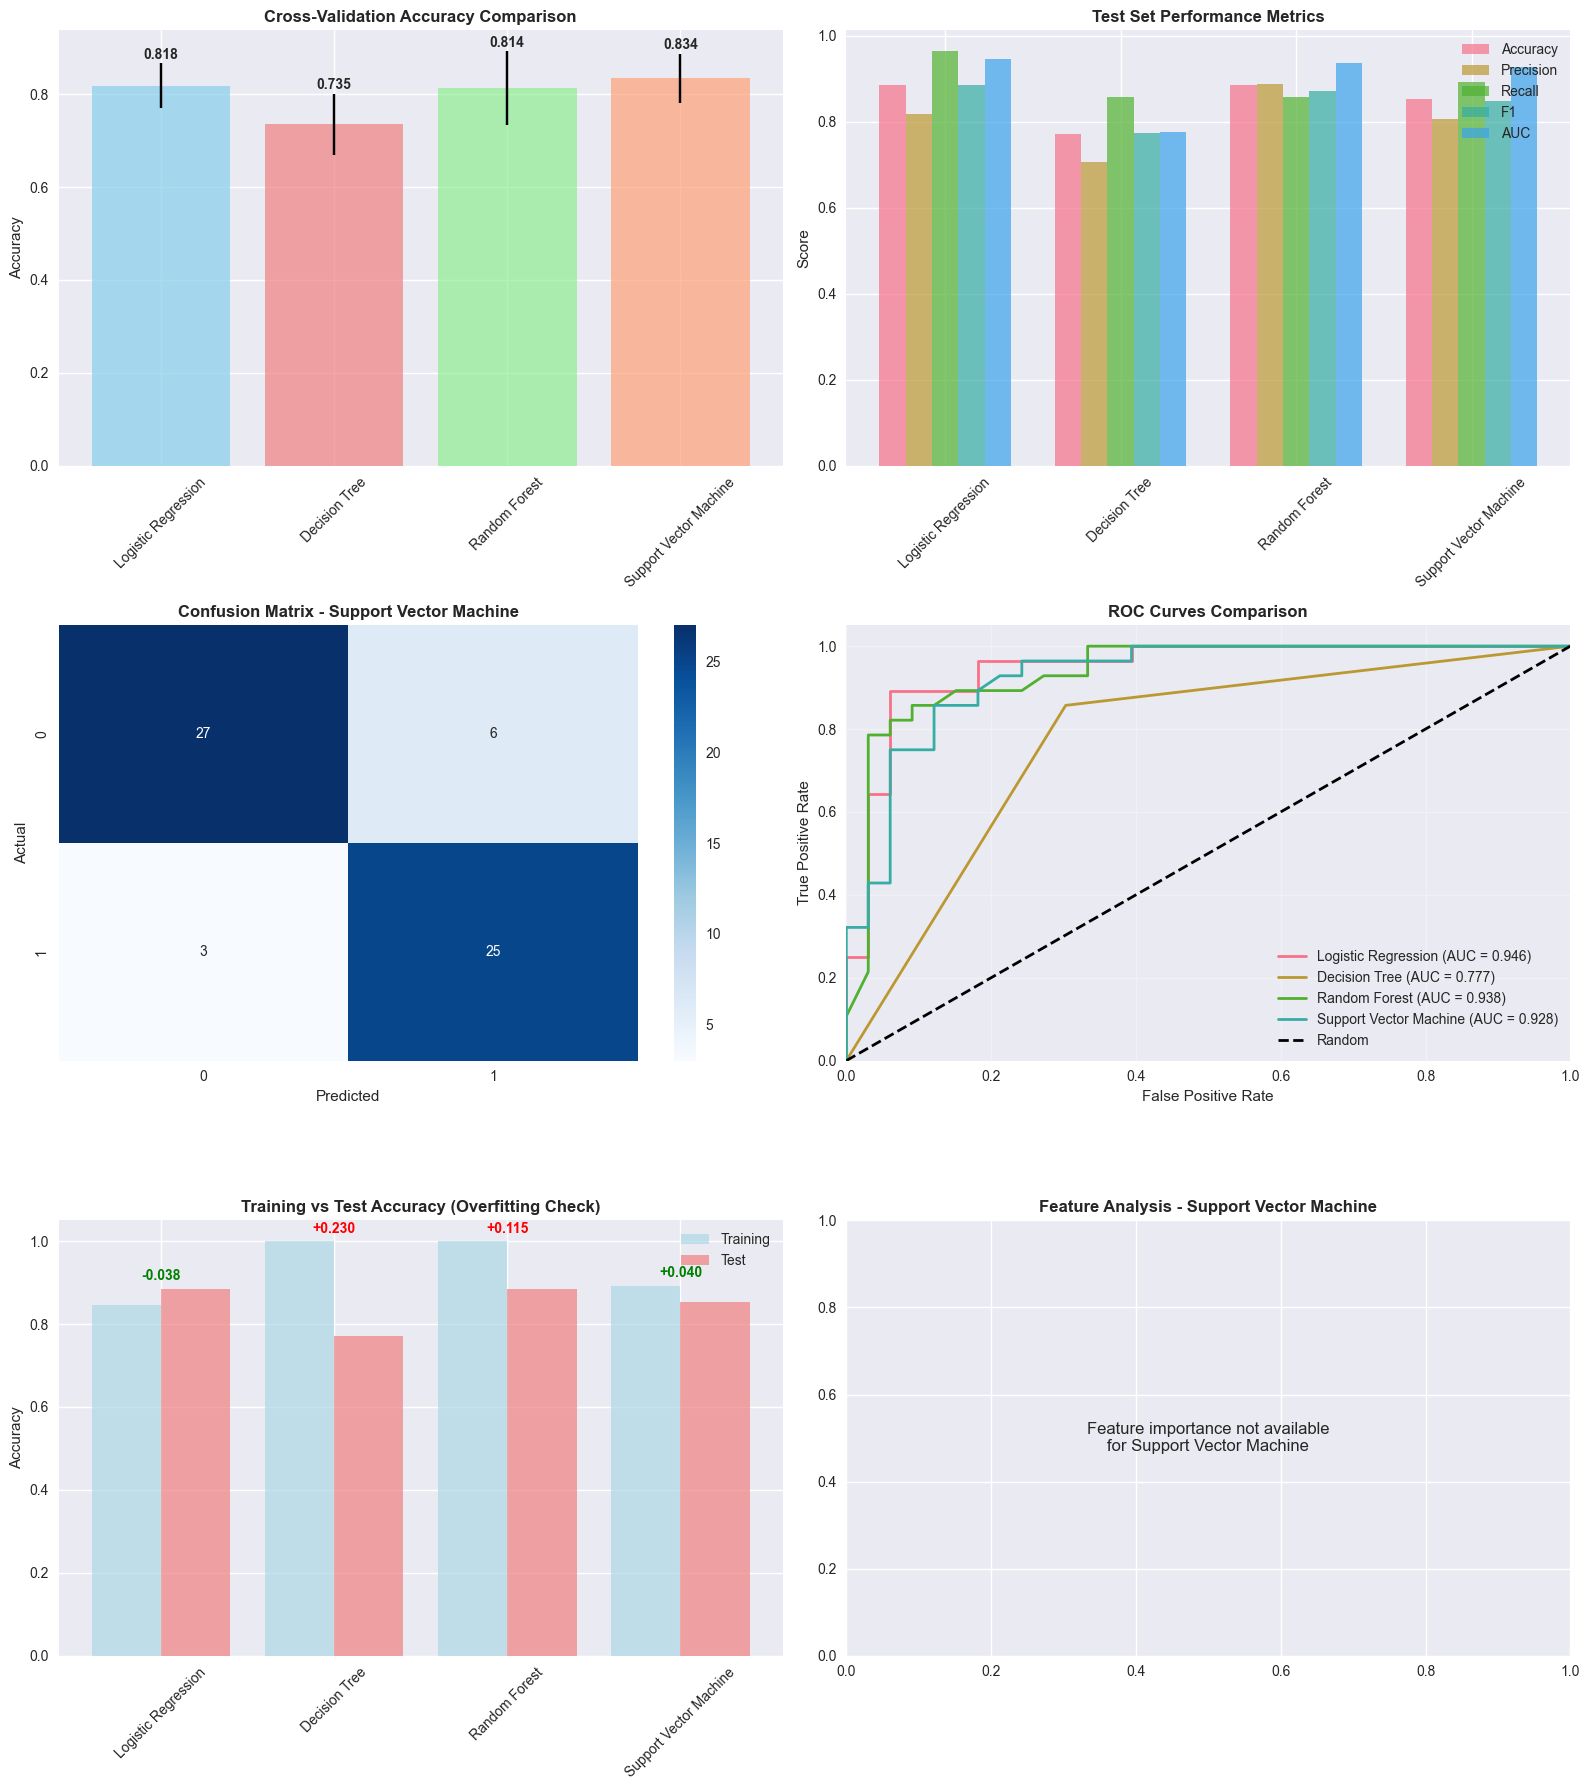

In [23]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

# 1. Cross-Validation Accuracy Comparison
models_names = results_df['Model']
cv_means = results_df['CV_Accuracy_Mean']
cv_stds = results_df['CV_Accuracy_Std']

axes[0,0].bar(models_names, cv_means, yerr=cv_stds, capsize=5, 
              color=['skyblue', 'lightcoral', 'lightgreen', 'lightsalmon'], alpha=0.7)
axes[0,0].set_title('Cross-Validation Accuracy Comparison', fontweight='bold')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].tick_params(axis='x', rotation=45)
for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
    axes[0,0].text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', fontweight='bold')

# 2. Test Set Performance Metrics
metrics = ['Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1', 'Test_AUC']
n_models = len(models_names)
x = np.arange(n_models)
width = 0.15

for i, metric in enumerate(metrics):
    values = results_df[metric]
    axes[0,1].bar(x + i*width, values, width, label=metric.replace('Test_', ''), alpha=0.7)

axes[0,1].set_title('Test Set Performance Metrics', fontweight='bold')
axes[0,1].set_ylabel('Score')
axes[0,1].set_xticks(x + width*2)
axes[0,1].set_xticklabels(models_names, rotation=45)
axes[0,1].legend()

# 3. Confusion Matrix for Best Model
best_y_pred = results[best_model_name]['y_test_pred']
cm = confusion_matrix(y_test, best_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1,0])
axes[1,0].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
axes[1,0].set_ylabel('Actual')
axes[1,0].set_xlabel('Predicted')

# 4. ROC Curves
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_test_proba'])
    auc_score = result['test_auc']
    axes[1,1].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})')

axes[1,1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
axes[1,1].set_xlim([0.0, 1.0])
axes[1,1].set_ylim([0.0, 1.05])
axes[1,1].set_xlabel('False Positive Rate')
axes[1,1].set_ylabel('True Positive Rate')
axes[1,1].set_title('ROC Curves Comparison', fontweight='bold')
axes[1,1].legend(loc="lower right")
axes[1,1].grid(True, alpha=0.3)

# 5. Training vs Test Accuracy (Overfitting Check)
train_acc = results_df['Train_Accuracy']
test_acc = results_df['Test_Accuracy']
x_pos = np.arange(len(models_names))

axes[2,0].bar(x_pos - 0.2, train_acc, 0.4, label='Training', alpha=0.7, color='lightblue')
axes[2,0].bar(x_pos + 0.2, test_acc, 0.4, label='Test', alpha=0.7, color='lightcoral')
axes[2,0].set_title('Training vs Test Accuracy (Overfitting Check)', fontweight='bold')
axes[2,0].set_ylabel('Accuracy')
axes[2,0].set_xticks(x_pos)
axes[2,0].set_xticklabels(models_names, rotation=45)
axes[2,0].legend()

# Add difference annotations
for i, (train, test) in enumerate(zip(train_acc, test_acc)):
    diff = train - test
    color = 'red' if diff > 0.05 else 'green'
    axes[2,0].text(i, max(train, test) + 0.02, f'{diff:+.3f}', 
                   ha='center', color=color, fontweight='bold')

# 6. Feature Importance (for tree-based models)
if best_model_name in ['Decision Tree', 'Random Forest']:
    feature_importance = best_model.feature_importances_
    feature_names = X_selected.columns
    
    # Sort features by importance
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=True)
    
    axes[2,1].barh(importance_df['Feature'], importance_df['Importance'], 
                   color='green', alpha=0.7)
    axes[2,1].set_title(f'Feature Importance - {best_model_name}', fontweight='bold')
    axes[2,1].set_xlabel('Importance')
else:
    # For non-tree models, show coefficient importance (for Logistic Regression)
    if best_model_name == 'Logistic Regression':
        coefficients = np.abs(best_model.coef_[0])
        feature_names = X_selected.columns
        
        coef_df = pd.DataFrame({
            'Feature': feature_names,
            'Coefficient': coefficients
        }).sort_values('Coefficient', ascending=True)
        
        axes[2,1].barh(coef_df['Feature'], coef_df['Coefficient'], 
                       color='purple', alpha=0.7)
        axes[2,1].set_title(f'Feature Coefficients - {best_model_name}', fontweight='bold')
        axes[2,1].set_xlabel('|Coefficient|')
    else:
        axes[2,1].text(0.5, 0.5, f'Feature importance not available\nfor {best_model_name}', 
                       ha='center', va='center', transform=axes[2,1].transAxes, fontsize=12)
        axes[2,1].set_title(f'Feature Analysis - {best_model_name}', fontweight='bold')

plt.tight_layout()
plt.show()

# ===============================
# 7. DETAILED CLASSIFICATION REPORTS
# ===============================

In [27]:
for name, result in results.items():
    print(f"\n {name}:")
    print("=" * (len(name) + 5))
    print(classification_report(y_test, result['y_test_pred']))


 Logistic Regression:
              precision    recall  f1-score   support

           0       0.96      0.82      0.89        33
           1       0.82      0.96      0.89        28

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.90      0.89      0.89        61


 Decision Tree:
              precision    recall  f1-score   support

           0       0.85      0.70      0.77        33
           1       0.71      0.86      0.77        28

    accuracy                           0.77        61
   macro avg       0.78      0.78      0.77        61
weighted avg       0.78      0.77      0.77        61


 Random Forest:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        33
           1       0.89      0.86      0.87        28

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg     

# ===============================
# 8. MODEL PERSISTENCE
# ===============================

In [25]:
import os
# Save all trained models
for name, result in results.items():
    model_filename = f"../Models/{name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(result['model'], model_filename)
    print(f" Saved {name} to '{model_filename}'")

# Save best model separately
best_model_filename = '../Models/best_model.pkl'
joblib.dump(best_model, best_model_filename)
print(f" Saved best model ({best_model_name}) to '{best_model_filename}'")

# Save model performance results
results_df.to_csv('../Results/supervised_learning_results.csv', index=False)
print(f" Saved results to '../Results/supervised_learning_results.csv'")

# Save detailed results as JSON
import json

detailed_results = {}
for name, result in results.items():
    detailed_results[name] = {
        'cv_accuracy_mean': float(result['cv_accuracy'].mean()),
        'cv_accuracy_std': float(result['cv_accuracy'].std()),
        'cv_precision_mean': float(result['cv_precision'].mean()),
        'cv_recall_mean': float(result['cv_recall'].mean()),
        'cv_f1_mean': float(result['cv_f1'].mean()),
        'train_accuracy': float(result['train_accuracy']),
        'test_accuracy': float(result['test_accuracy']),
        'test_precision': float(result['test_precision']),
        'test_recall': float(result['test_recall']),
        'test_f1': float(result['test_f1']),
        'test_auc': float(result['test_auc'])
    }

detailed_results['best_model'] = best_model_name
detailed_results['dataset_info'] = {
    'n_features': X_selected.shape[1],
    'n_train_samples': X_train.shape[0],
    'n_test_samples': X_test.shape[0],
    'selected_features': list(X_selected.columns)
}

# with open('../Results/supervised_learning_detailed.json', 'w') as f:
#     json.dump(detailed_results, f, indent=4)

# print(f" Saved detailed results to '../Results/supervised_learning_detailed.json'")

# Save summary text report
with open('../Results/supervised_learning_summary.txt', 'w') as f:
    f.write("HEART DISEASE PREDICTION - SUPERVISED LEARNING SUMMARY\n")
    f.write("=" * 60 + "\n")
    f.write(f"Dataset: {X_selected.shape[0]} samples, {X_selected.shape[1]} features\n")
    f.write(f"Train/Test Split: {X_train.shape[0]}/{X_test.shape[0]} samples\n")
    f.write(f"Cross-Validation: {cv_folds}-fold Stratified\n\n")
    
    f.write("MODEL PERFORMANCE SUMMARY:\n")
    f.write("-" * 30 + "\n")
    for _, row in results_df.iterrows():
        f.write(f"{row['Model']}:\n")
        f.write(f"  • CV Accuracy: {row['CV_Accuracy_Mean']:.4f} ± {row['CV_Accuracy_Std']:.4f}\n")
        f.write(f"  • Test Accuracy: {row['Test_Accuracy']:.4f}\n")
        f.write(f"  • Test Precision: {row['Test_Precision']:.4f}\n")
        f.write(f"  • Test Recall: {row['Test_Recall']:.4f}\n")
        f.write(f"  • Test F1-Score: {row['Test_F1']:.4f}\n")
        f.write(f"  • Test AUC: {row['Test_AUC']:.4f}\n\n")
    
    f.write(f"BEST MODEL: {best_model_name}\n")
    f.write(f"Best CV Accuracy: {results_df.loc[best_model_idx, 'CV_Accuracy_Mean']:.4f}\n")
    f.write(f"Best Test Accuracy: {results_df.loc[best_model_idx, 'Test_Accuracy']:.4f}\n")
    f.write(f"Best Test AUC: {results_df.loc[best_model_idx, 'Test_AUC']:.4f}\n")

print(f" Saved summary to '../Results/supervised_learning_summary.txt'")


 Saved Logistic Regression to '../Models/logistic_regression_model.pkl'
 Saved Decision Tree to '../Models/decision_tree_model.pkl'
 Saved Random Forest to '../Models/random_forest_model.pkl'
 Saved Support Vector Machine to '../Models/support_vector_machine_model.pkl'
 Saved best model (Support Vector Machine) to '../Models/best_model.pkl'
 Saved results to '../Results/supervised_learning_results.csv'
 Saved summary to '../Results/supervised_learning_summary.txt'
